In [1]:
from gnuradio import channels, gr, blocks, analog, digital
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import sigmf
from sigmf import SigMFFile
from signals.comms import modulations, bpsk
from pathlib import Path

## Global Variables

In [2]:
# Channel parameters
snr = 13
noise_voltage = 10**(-snr/20)
nSamples = int(1e3)
# Modulation parameteres
sampRate = 200e3
sampsPerSym = 2
symRate = sampRate / sampsPerSym
# Metadata setup
dataDir = 'data/'
filename = 'dataset'
# Create directory if it doesn't exist
Path(dataDir).mkdir(parents=True, exist_ok=True)
# Open and close the data file to create it if it doesn't exist. This is
# necessary for the SigMFFile object below
datafile = open(dataDir+filename+'.sigmf-data','w+')
datafile.close()
meta = SigMFFile(
  data_file=dataDir+filename+'.sigmf-data',
  global_info={
    SigMFFile.DATATYPE_KEY: 'cf32_le',
    SigMFFile.SAMPLE_RATE_KEY: sampRate,
    SigMFFile.AUTHOR_KEY: 'Shane Flandermeyer, shane.flandermeyer@ou.edu',
    SigMFFile.DESCRIPTION_KEY: 'Synthetic RF dataset for machine learning',
    SigMFFile.VERSION_KEY: sigmf.__version__,
  }
)


## Now do it in a loop

In [3]:
# Number of vectors per modulation class
nVecClass = 1000
# Number of samples per vector
nSamplesVec = 128

# Loop through all the available modulation types
data = np.zeros((0,), dtype=np.complex64)
# A running cound of the number of samples produced
nSamplesProduced = 0
nIterations = 0
for alphabet_type in modulations.keys():
    for ii, modulation_type in enumerate(modulations[alphabet_type]):
        sig = modulation_type()
        # Generate bits
        src = analog.random_uniform_source_b(0, 256, 0)
        # Symbol constellation
        constellation = sig.constellation
        # Constellation modulator
        mod = digital.generic_mod(
            constellation=constellation,
            differential=False,
            samples_per_symbol=2,
            pre_diff_code=True,
            excess_bw=0.35,
            verbose=False,
            log=False,
            truncate=False)
        channel = channels.channel_model(noise_voltage=noise_voltage, taps=[1])
        # Head block to limit the number of samples
        head = blocks.head(gr.sizeof_char, nSamples)
        # Vector sink
        sink = blocks.vector_sink_c()
        # Create and run the flowgraph
        tb = gr.top_block()
        tb.connect(src, head, mod, channel, sink)
        tb.run()
        data = np.append(data,np.array(sink.data(), dtype=np.complex64))
        # Create the metadata dictionary
        # TODO: This isn't too bad, but I can do even better
        detail = sig.detail
        metaDict = {SigMFFile.DATETIME_KEY: dt.datetime.utcnow().isoformat()+'Z'}
        metaDict[sig.DETAIL_KEY] = detail.dict()    
        meta.add_capture(nSamplesProduced, metadata=metaDict)
        nSamplesProduced += sink.nitems_read(0)
        
        nIterations += 1
        

print(f'Created {nIterations} sample vectors')
# Check for mistakes and write to disk
data.tofile(dataDir+filename+'.sigmf-data')
assert meta.validate()
meta.tofile(dataDir+filename) # extension is optional

Created 2 sample vectors


## Post Processing

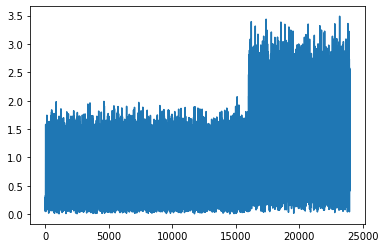

In [4]:
test = np.fromfile(dataDir+filename+'.sigmf-data', dtype=np.complex64)
plt.plot(np.abs(test))